In [1]:
import george
import matplotlib.pyplot as plt
import numba
import numpy as np
from numpy.ma import masked_inside, masked_greater
from george import kernels
from hyperopt import STATUS_OK, fmin, hp, tpe
from sklearn.model_selection import KFold
from methodtools import lru_cache

In [2]:
# Step 1: Create a synthetic dataset

rng = np.random.RandomState(6)

num = 500
num_train = 50

x = np.linspace(1, 100, num)
y_no_noise = x / 100 * np.sin(0.03 * np.pi * x)

x_masked = masked_greater(x, 80)
x_masked = masked_inside(x_masked, 20, 30)

training_indices = np.sort(
    rng.choice(np.arange(x_masked.size)[~x_masked.mask], size=num_train, replace=False)
)
X, y = x[training_indices], y_no_noise[training_indices]
y += rng.normal(0, 0.1, num_train)

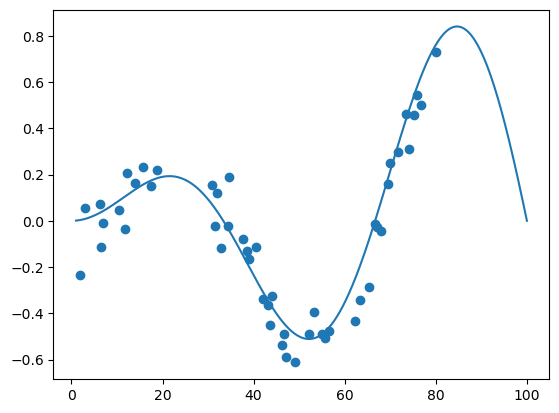

In [3]:
plt.plot(x, y_no_noise)
plt.scatter(X, y)

In [274]:
@numba.jit(nopython=True)
def compiled_log_pseudo_likelihood(y, mu, sigma):
    k = len(y)
    log_det = np.sum(np.log(sigma))
    squared_diff_sum = np.sum(((y - mu) / sigma) ** 2)

    log_predictive_prob = (
        -0.5 * k * np.log(2 * np.pi) - log_det - 0.5 * squared_diff_sum
    )
    return log_predictive_prob


class LOOCV_GP(george.GP):
    def _compute_K_inv(self, y, cache):
        # Recalculate K_inv only if y is not the same as the previous y.
        if not cache:
            K_inv = np.ascontiguousarray(self.solver.get_inverse())
            K_inv_diag = np.ascontiguousarray(np.diag(K_inv))

            return K_inv, K_inv_diag
        if self._alpha is None or not np.array_equiv(y, self._y):
            K_inv = np.ascontiguousarray(self.solver.get_inverse())
            K_inv_diag = np.ascontiguousarray(np.diag(K_inv))

            self._K_inv = K_inv
            self._K_inv_diag = K_inv_diag
        return self._K_inv, self._K_inv_diag

    def compute_predictive_estimates(self, y, cache=True):
        # calculate predictive mean and standard deviation from leave-one-out cross validation
        K_inv, K_inv_diag = self._compute_K_inv(y, cache=cache)

        mu = y - self.apply_inverse(y) / K_inv_diag
        sigma = 1 / np.sqrt(K_inv_diag**2)
        return mu, sigma

    def log_pseudo_likelihood(self, y, quiet=False, cache=True):
        if not self.recompute(quiet=quiet):
            return -np.inf

        if len(np.unique(self._x)) != len(self._x):
            raise NotImplementedError(
                "There are duplicates in X. Leave-one-out Cross-Validation not implemented for this case."
            )

        try:
            mu = self._call_mean(self._x)
        except ValueError:
            if quiet:
                return -np.inf
            raise
        r = np.ascontiguousarray(self._check_dimensions(y) - mu, dtype=np.float64)

        predictive_mu, predictive_sigma = self.compute_predictive_estimates(
            y, cache=cache
        )
        return compiled_log_pseudo_likelihood(r, predictive_mu, predictive_sigma)

    def grad_log_pseudo_likelihood(self, y, quiet=False, cache=True):
        # Make sure that the model is computed and try to recompute it if it's
        # dirty.
        if not self.recompute(quiet=quiet):
            return np.zeros(len(self), dtype=np.float64)

        # Pre-compute some factors.
        try:
            alpha = self._compute_alpha(y, False)
        except ValueError:
            if quiet:
                return np.zeros(len(self), dtype=np.float64)
            raise

        if len(self.white_noise) or len(self.kernel):
            K_inv, K_inv_diag = self._compute_K_inv(y, cache=cache)

        # Compute each component of the gradient.
        grad = np.empty(len(self))
        n = 0

        l = len(self.mean)
        if l:
            try:
                mu = self._call_mean_gradient(self._x)
            except ValueError:
                if quiet:
                    return np.zeros(len(self), dtype=np.float64)
                raise
            grad[n : n + l] = np.dot(mu, alpha)
            n += l

        l = len(self.white_noise)
        if l:
            wn = self._call_white_noise(self._x)
            wng = self._call_white_noise_gradient(self._x)
            grad[n : n + l] = 0.5 * np.sum(
                (np.exp(wn) * np.diag(A))[None, :] * wng, axis=1
            )
            n += l

        l = len(self.kernel)
        if l:
            Kg = self.kernel.get_gradient(self._x)
            Z = np.ascontiguousarray(np.einsum("ij,jkl", K_inv, Kg))
            Za = np.ascontiguousarray(np.einsum("ijk,j", Z, alpha))
            Zk_diag = np.ascontiguousarray(np.einsum("ijk,ji->ik", Z, K_inv))

            term_1 = (alpha / K_inv_diag) @ Za
            term_2 = -0.5 * np.einsum("ik, i", Zk_diag, 1 / K_inv_diag)
            term_3 = -0.5 * np.einsum("i, ik", (alpha / K_inv_diag) ** 2, Zk_diag)
            grad[n : n + l] = term_1 + term_2 + term_3
        return grad

    def nlpl(self, vector, y, quiet=True, cache=True):
        self.set_parameter_vector(vector)
        if not np.isfinite(self.log_prior()):
            return np.inf
        return -self.log_pseudo_likelihood(
            y,
            quiet=quiet,
            cache=cache,
        )

    def grad_nlpl(self, vector, y, quiet=True, cache=True):
        self.set_parameter_vector(vector)
        if not np.isfinite(self.log_prior()):
            return np.zeros(len(vector))
        return -self.grad_log_pseudo_likelihood(
            y,
            quiet=quiet,
            cache=cache,
        )

In [275]:
mask = np.full_like(X, True, dtype=bool)
mask[45] = False

In [276]:
yerr = 0.2

kernel = 6 * kernels.ExpSquaredKernel(3)
gp = LOOCV_GP(kernel)
gp.compute(X[mask], yerr=yerr)

kernel2 = 6 * kernels.ExpSquaredKernel(3)
gp2 = LOOCV_GP(kernel2)
gp2.compute(X, yerr=yerr)

In [277]:
gp.predict(y[mask], X[45])

(array([0.46296151]), array([[0.06143291]]))

In [278]:
gp2.compute_predictive_estimates(y)[1][45]

0.10143291478232194

In [285]:
qn = gp2.apply_inverse(y)
_, Kinv_diag = gp2._compute_K_inv(y, False)

In [287]:
(
    -0.5 * np.sum(*(qn**2 / Kinv_diag))
    + 0.5 * np.sum(np.log(Kinv_diag))
    - np.log(2 * np.pi) * len(Kinv_diag)
)

-16.422117216547942

In [288]:
gp2.log_pseudo_likelihood(y)

-6.999050569334262

## optimimzation

In [30]:
from scipy.optimize import minimize

In [31]:
x0 = [1, 1]
p1 = minimize(gp.nll, x0=x0, jac=gp.grad_nll, args=(y)).x

In [32]:
x0 = [1, 1]
p2 = minimize(
    gp.nlpl,
    x0=x0,
    # jac=gp.grad_nlpl,
    args=(y),
).x
p2

array([0.69916238, 6.21683195])

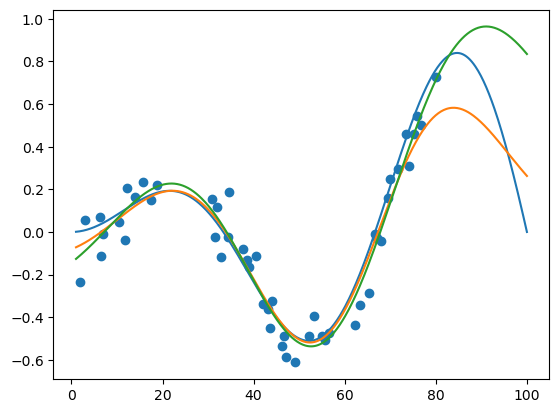

In [459]:
plt.plot(x, y_no_noise)
plt.scatter(X, y)

gp.set_parameter_vector(p1)
plt.plot(x, gp.predict(y, x, return_cov=False))

gp.set_parameter_vector(p2)
plt.plot(x, gp.predict(y, x, return_cov=False))